# <span style="color: green;">Feature Engineering, WOE and IV </span>

**Goal of this tutorial**

- Understand feature enginering and  its importance

- Key elements of feature enginering

- Best Practices in Feature Engineering

- Weight of Evidence (WoE) and Information Value (IV)


## Introduction

Feature engineering, Weight of Evidence (WOE), and Information Value (IV) are related concepts primarily used in the context of building predictive models, particularly in credit risk modeling and other classification tasks.





<div style="height:40px"></div>


## <span style="color: red;">What is feature enginering and Understand its importance? </span>

- Process of transforming raw data into meaningful features. It is an iterative process with multiple steps.

It is important:

- Improves machine learning model acuracy/performance.

Example: converting a date column into “day of the week” or “holiday vs. non-holiday” can improve sales forecasting models.

-  Enhances Model Interpretability

Example: In fraud detection, a feature like "number of transactions per hour" is more informative than raw timestamps.

- Reduces Overfitting and Underfitting

- Boosts Training Efficiency: Reducing the number of unnecessary features decreases computational complexity, making training faster and more efficient.

- Handles Noisy and Missing Data: helps to clean and structure incomplete or outlier containing  data, ensuring better learning outcomes.


## <span style="color: red;">Key elements of feature enginering
 </span>


<p align="center">
 <img src="../image/image.png" width="600"/>
</p>


# Comparison: Good vs Bad Feature Engineering

| Aspect                     | Good Feature Engineering                                      | Bad Feature Engineering                                    |
|----------------------------|---------------------------------------------------------------|------------------------------------------------------------|
| **Feature Selection**      | Select features based on predictive power (IV, correlation). Example: Using `CreditScore`, `Income`, `Age_Bucketed` | Include irrelevant or redundant features. Example: Using `CustomerID`, `RandomNumber1` |
| **Handling Missing Values**| Impute missing values sensibly. Example: Fill missing `Income` with median | Drop rows randomly or leave missing values. Example: Leaving `CreditScore` as NaN |
| **Encoding Categorical**   | Use meaningful encodings. Example: `Gender` → WOE or One-Hot | Assign arbitrary numbers without meaning. Example: `Gender` → Male=1, Female=2 |
| **Scaling / Normalization**| Scale numerical features. Example: StandardScaler on `Income` and `LoanAmount` | Leave features in different scales. Example: `Income` in 1000s vs `Age` in years without scaling |
| **Feature Creation**       | Generate features that add predictive value. Example: `Income / LoanAmount`, `Age_Bucketed` | Create arbitrary features without justification. Example: `RandomRatio = Age * 7 / 3` |
| **Avoiding Data Leakage**  | Use only features available at prediction time. Example: Use past transactions only | Use future or target-related features. Example: Including `DefaultedNextMonth` |
| **Model Interpretability** | Features are interpretable. Example: WOE-transformed features for logistic regression | Features are opaque. Example: Raw hashed IDs or meaningless encodings |



Data Collection → Cleaning → Feature Creation → Transformation → Selection → Modeling → Iteration



# Steps for Feature enginering

<p align="center">
 <img src="../image/cycle.png" width="600"/>
</p>

In [84]:
import sys
import os

# Get absolute path to the project root (one directory up from notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

print(project_root)

D:\Emma


In [85]:
import importlib.util
import sys
import os

module_path = r'D:\Emma\feature_engineering_woe_iv\scripts\data_loader.py'

spec = importlib.util.spec_from_file_location("data_loader", module_path)
data_loader = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_loader)

# now you can access your function
load_data = data_loader.load_data

# test
print(load_data)


<function load_data at 0x0000017561998C20>


In [86]:
#python standard module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
# Load Excel file
df = load_data(r"D:\Emma\feature_engineering_woe_iv\data\loan.xlsx")

# Data cleaning

In [88]:
#Initial exploration
print(df.head())


    Loan_ID Gender Married Self_Employed  ApplicantIncome  CoapplicantIncome  \
0  LP001002   Male      No            No             5849                0.0   
1  LP001003   Male     Yes            No             4583             1508.0   
2  LP001005   Male     Yes           Yes             3000                0.0   
3  LP001006   Male     Yes            No             2583             2358.0   
4  LP001008   Male      No            No             6000                0.0   

   LoanAmount  Loan_Amount_Term Loan_Status  
0         NaN             360.0           Y  
1       128.0             360.0           N  
2        66.0             360.0           Y  
3       120.0             360.0           Y  
4       141.0             360.0           Y  


In [89]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Self_Employed      582 non-null    object 
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         592 non-null    float64
 7   Loan_Amount_Term   600 non-null    float64
 8   Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 43.3+ KB
None


In [90]:
print(df.describe())


       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term
count       614.000000         614.000000  592.000000         600.00000
mean       5403.459283        1621.245798  146.412162         342.00000
std        6109.041673        2926.248369   85.587325          65.12041
min         150.000000           0.000000    9.000000          12.00000
25%        2877.500000           0.000000  100.000000         360.00000
50%        3812.500000        1188.500000  128.000000         360.00000
75%        5795.000000        2297.250000  168.000000         360.00000
max       81000.000000       41667.000000  700.000000         480.00000


Interpretation:

- Income and loan amounts show strong skew and contain outliers that may need transformation or cleaning.

- Coapplicant income is often zero — important when modelling credit risk.

- Loan terms cluster around 360 months, which is typical for home loans.

- Some features have missing values (LoanAmount and Loan_Amount_Term).

In [91]:
#print(df.isnull().sum())  # check missing values
print(df.duplicated().sum())  # check duplicate

0


In [92]:
#missing value proportion
null_val_sums = df.isnull().sum()
pd.DataFrame({"Column": null_val_sums.index, "Number of Null Values": null_val_sums.values,
"Proportion": null_val_sums.values / len(df) })


,Column,Number of Null Values,Proportion
0,Loan_ID,0,0.000000
1,Gender,13,0.021173
2,Married,3,0.004886
3,Self_Employed,32,0.052117
4,ApplicantIncome,0,0.000000
5,CoapplicantIncome,0,0.000000
6,LoanAmount,22,0.035831
7,Loan_Amount_Term,14,0.022801
8,Loan_Status,0,0.000000


In [93]:
# data types

In [94]:
#lists the columns with categorical data
object_train_df=df.select_dtypes(include=['object'])    
object_train_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Self_Employed', 'Loan_Status'], dtype='object')

In [95]:
#lists the columns with numerical data
num_train_df=df.select_dtypes(include=['int','float'])     
num_train_df.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term'],
      dtype='object')

## Visualizing

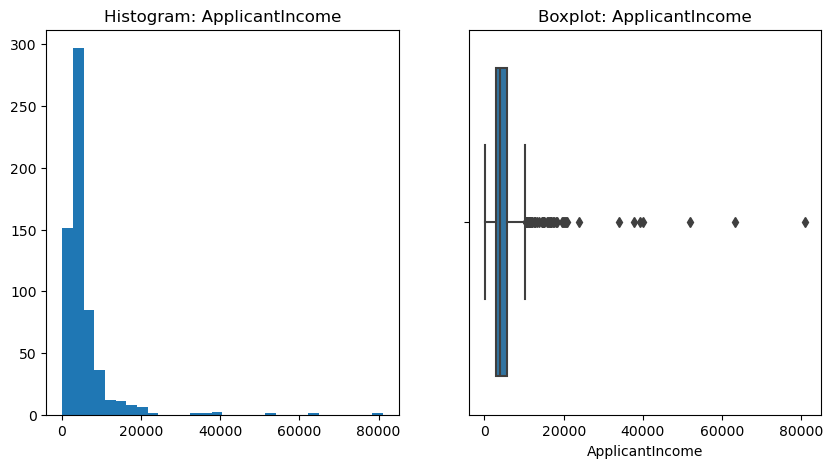

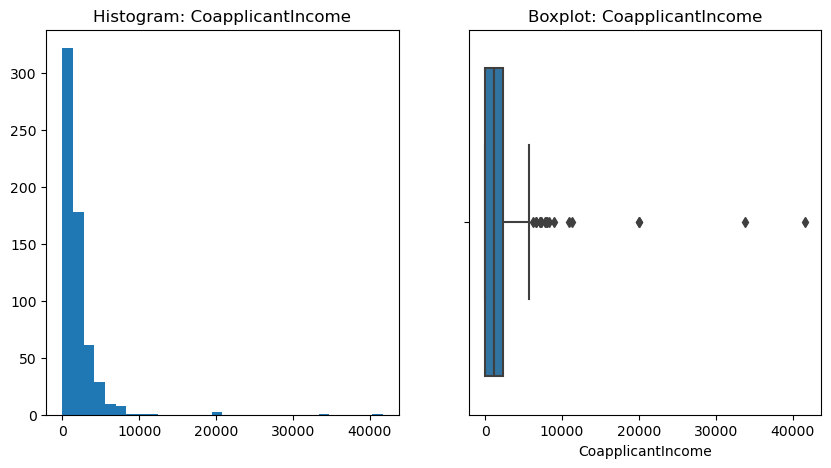

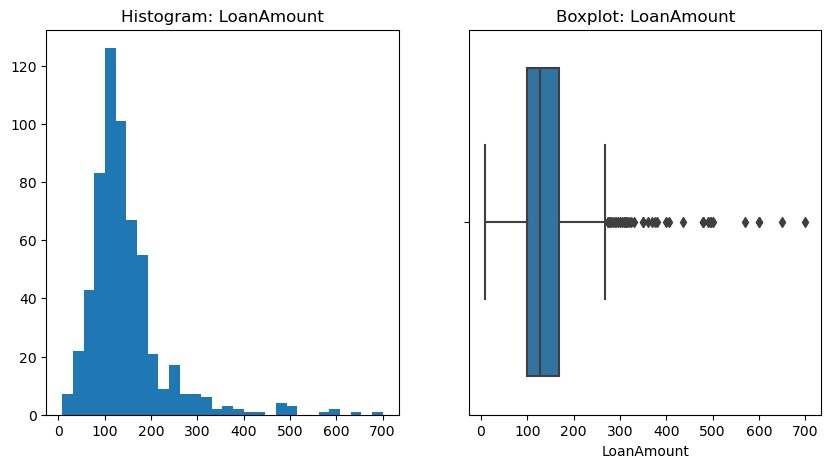

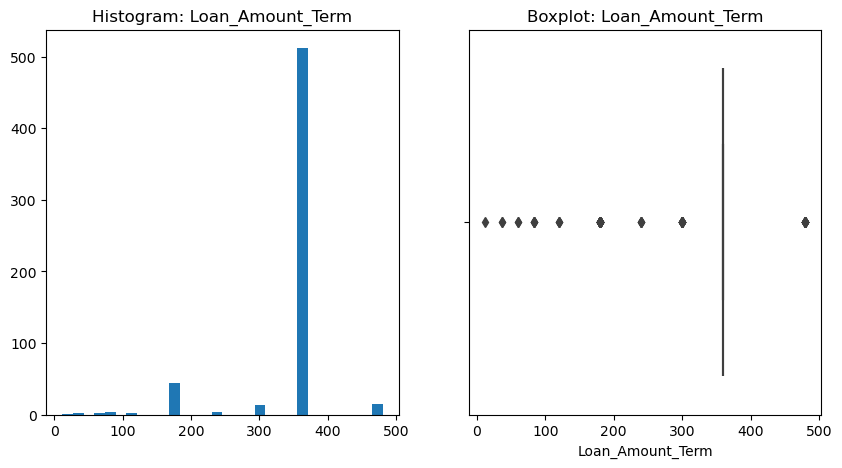

In [96]:
 #Visualize distributions
# ===============================

numeric_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]

for col in numeric_cols:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram: {col}")

    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
    plt.show()

In [97]:
#Detect outliers (IQR method)
# ===============================

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers, lower, upper

for col in numeric_cols:
    outliers, low, high = detect_outliers_iqr(df, col)
    print(f"\nColumn: {col}")
    print(f"Lower Bound: {low}, Upper Bound: {high}")
    print(f"Outliers detected: {len(outliers)}")


Column: ApplicantIncome
Lower Bound: -1498.75, Upper Bound: 10171.25
Outliers detected: 50

Column: CoapplicantIncome
Lower Bound: -3445.875, Upper Bound: 5743.125
Outliers detected: 18

Column: LoanAmount
Lower Bound: -2.0, Upper Bound: 270.0
Outliers detected: 39

Column: Loan_Amount_Term
Lower Bound: 360.0, Upper Bound: 360.0
Outliers detected: 88


Interpretation:

- ApplicantIncome and CoapplicantIncome:
A small number of applicants have very high incomes → positive skew. Here above the upper bound is considered as an outlier and since lower bounds are negative and since there is no negative income , no lower outlier. Also, there are 50 applicants whose income is above this threshold for applicants income and 18 for coapplicants.

- LoanAmount:
Most loans are moderate-sized; a few large loans exist → outliers detected. That is. any LoanAmount above 270 (thousands) is an outlier and  39 loans with unusually large loan amounts but lower bound is –2 → impossible, so no low-end outliers.

- Loan_Amount_Term:
The dataset is dominated by 360-month loans → any other term looks like an outlier. i.e. the vast majority of terms are 360 months, so the IQR method considers:
any value that is NOT 360 as an outlier. So all loan terms like 12, 36, 60, 180, 240, 480 become outliers and for our data there are 88 such “unusual” loan terms, but these are valid loan durations, not errors.

Suggestion:

- Use log transformation for skewed numeric features.

- Treat Loan_Amount_Term as categorical, not numeric.

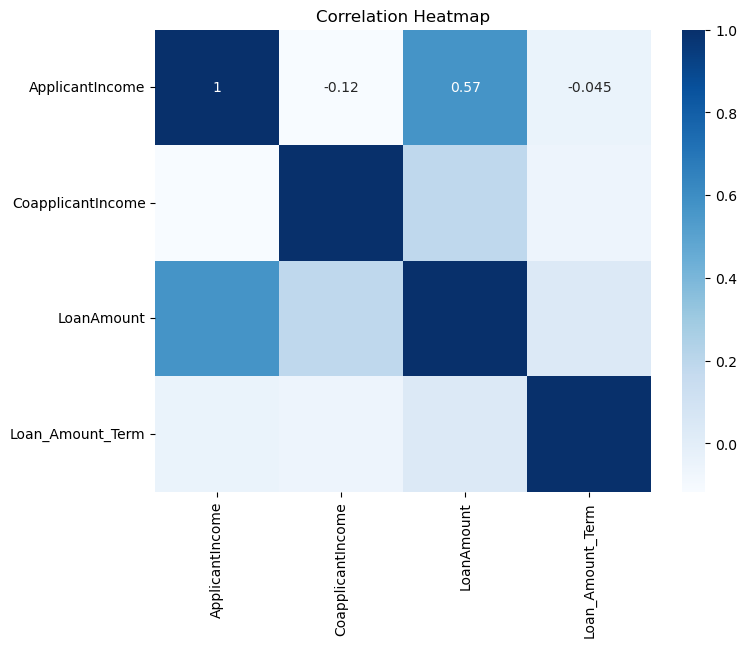

In [98]:
#Correlation matrix
# ===============================

plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()


# Interpretation

- ApplicantIncome \& LoanAmount (0.57): Moderate positive correlation. 
This suggests ApplicantIncome is an important predictor for LoanAmount or loan approval.

- ApplicantIncome \& CoapplicantIncome (-0.12):Very weak negative correlation. Having both features might still provide additional predictive power.

- CoapplicantIncome \& LoanAmount (0.18):Weak positive correlation.
Coapplicant income contributes somewhat to predicting loan amounts but is less important than the applicant’s income.

- Loan_Amount_Term correlations: Very weak correlations with all other features (close to 0).
This suggests it might not have a linear relationship with the other features, but could still be relevant in non-linear models.

# Feature Extraction Suggestions

- Combine Income Features

TotalIncome = ApplicantIncome + CoapplicantIncome

This could capture the combined financial strength of the applicants.

- Income-to-Loan Ratio

Income_to_Loan_Ratio = TotalIncome / LoanAmount

Useful for evaluating repayment capacity.

- Log Transformation

Income and LoanAmount often have skewed distributions. Use log transformations:

'''df['Log_ApplicantIncome'] = np.log1p(df['ApplicantIncome'])

df['Log_LoanAmount'] = np.log1p(df['LoanAmount'])'''


Helps stabilize variance and improve model performance.

- Binning

You could bin Loan_Amount_Term into categories (short, medium, long term) for models that benefit from categorical features.

- Interaction Features

Multiply or divide features that might have joint effects:

ApplicantIncome * Loan_Amount_Term

LoanAmount / ApplicantIncome

- Polynomial Features

Consider creating polynomial terms (squared or cubic) for features with moderate correlations like ApplicantIncome.

In [99]:
#Preprocessing suggestions + cleaning
# ===============================

# Fill missing LoanAmount using median
df["LoanAmount"].fillna(df["LoanAmount"].median(), inplace=True)

# Fill missing Loan_Amount_Term using mode (most common = 360)
df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].mode()[0], inplace=True)



In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Self_Employed      582 non-null    object 
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         614 non-null    float64
 7   Loan_Amount_Term   614 non-null    float64
 8   Loan_Status        614 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 43.3+ KB


In [101]:
# Log transformation for skewed income columns
df["ApplicantIncome_log"] = np.log1p(df["ApplicantIncome"])
df["CoapplicantIncome_log"] = np.log1p(df["CoapplicantIncome"])
df["LoanAmount_log"] = np.log1p(df["LoanAmount"])

In [102]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Loan_Status',
       'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log'],
      dtype='object')

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Loan_ID                614 non-null    object 
 1   Gender                 601 non-null    object 
 2   Married                611 non-null    object 
 3   Self_Employed          582 non-null    object 
 4   ApplicantIncome        614 non-null    int64  
 5   CoapplicantIncome      614 non-null    float64
 6   LoanAmount             614 non-null    float64
 7   Loan_Amount_Term       614 non-null    float64
 8   Loan_Status            614 non-null    object 
 9   ApplicantIncome_log    614 non-null    float64
 10  CoapplicantIncome_log  614 non-null    float64
 11  LoanAmount_log         614 non-null    float64
dtypes: float64(6), int64(1), object(5)
memory usage: 57.7+ KB



 Key Elements of Feature Engineering
<!--

1. Handling Missing Values

Why: Missing data causes bias or model errors.

Methods: Mean/median fill, forward fill, using a special category (“Unknown”), model-based imputation.

Example:

Replace missing age with median age.


2. Encoding Categorical Variables

Why: Models need numbers, not strings.

Methods: One-hot encoding, label encoding, target encoding.

Example:

Convert "Red", "Blue", "Green" into three binary columns.

3. Feature Transformation

Why: Reduce skew, improve linear separability.

Methods: Log transform, Box-Cox, Power transform.

Example:

Apply log(x + 1) to transaction amounts.

5. Feature Creation

Why: Combine or generate meaningful features that help the model.

Methods: Polynomial features, interaction terms, domain-based features.

Example:

From date: extract day, month, year, is_weekend.

6. Feature Selection

Why: Remove noisy or irrelevant features to reduce overfitting.

Methods: Variance threshold, correlation analysis, model-based selection.

Example:

Drop features with >0.95 correlation

7. Outlier Handling

Why: Outliers damage scaling and model stability.

Methods: Capping (winsorizing), removal, robust transformations.

Example:

Clip values above 99th percentile.

8. Discretization / Binning

Why: Helps for noisy continuous variables.

Methods: Equal-width bins, equal-frequency bins, custom rule-based bins.

Example:

Convert age into “child/adult/senior”.
-->

#  Best Practices in Feature Engineering

1. Understanding the Business Problem Before Selecting Features

2. Avoiding Data Leakage Through Careful Feature Selection: Data leakage occurs when information from the training set is inadvertently included in the test set.

        - Exclude features that wouldn’t be available at the time of prediction.
        - Avoid using future information in training data.

        - Be cautious with derived features based on target variables.

3. Experimenting with Different Transformations and Encodings

        -  Scaling numerical variables (Min-Max Scaling, Standardization) to ensure consistency.

        - Encoding categorical variables (One-Hot, Label Encoding, Target Encoding) based on data distribution.

        - Applying transformations (Log, Square Root, Power Transform) to normalize skewed data.

4. Validating Engineered Features Using Visualization and Correlation Analysis

      - Use histograms and box plots to check feature distributions.

      - Use scatter plots and correlation heatmaps to identify relationships between variables.

      - Remove highly correlated features to prevent multicollinearity.

5. Testing Features with Different Models to Evaluate Impact

      - Train multiple models (Linear Regression, Decision Trees, Neural Networks) and compare feature importance.

      - Use Permutation Importance or SHAP values to understand each feature’s contribution.

      - Perform Ablation Studies (removing one feature at a time) to measure performance impact.

#  Weight of Evidence (WoE) and Information Value (IV)

## Weight of Evidence (WoE)

 A transformation that measures the relationship between a feature's category (or bin) and the target variable (event/non-event).

 How it works: For each bin, it calculates the natural log of the ratio of % non-events to % events (or vice-versa).

 # Feature Engineering, WOE, and IV for Loan Status Prediction

## Feature Engineering
**What:** Transform raw data into useful features.  
**Why:** Better features improve model accuracy.  
**How:**  
- Encode categorical variables (`Gender`, `Married`)  
- Create new features (`TotalIncome = ApplicantIncome + CoapplicantIncome`)  
- Bin continuous variables (`LoanAmount` ranges)  
- Handle missing values  

**Example:**
```python
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['LoanAmount_Bin'] = pd.qcut(df['LoanAmount'], 4, labels=False)
df['Married'] = df['Married'].map({'Yes':1, 'No':0})

## Weight of Evidence (WOE)

**What:** Encode variables based on ratio of approved vs rejected loans.  
**Why:** Provides monotonic, interpretable features for logistic regression.  

**How:**  
\[
\text{WOE} = \ln\left(\frac{\% \text{Approved}}{\% \text{Rejected}}\right)
\]  

**Example:**  
For `Married` variable:  
- Approved: 80, Rejected: 20 → `%Approved = 0.8`, `%Rejected = 0.2`  
- `WOE = ln(0.8 / 0.2) ≈ 1.39`  

---

## Information Value (IV)

**What:** Measures how strongly a variable predicts loan approval.  
**Why:** Helps select the most predictive features.  

**How:**  
\[
\text{IV} = (\% \text{Approved} - \% \text{Rejected}) \times \text{WOE}
\]  

**Example:**  
For `Married` variable:  
- `%Approved - %Rejected = 0.8 - 0.2 = 0.6`  
- `IV = 0.6 * 1.39 ≈ 0.83` → Strong predictor





# Step-by-Step How to Apply WOE + IV to Predict Loan Status:

1. Convert Loan_Status into good/bad (0/1)

2. Identify variables for WOE

3. Bin numeric variables

4. Compute WOE and IV per bin

5. Evaluate IV and choose strong predictors

6. Transform the dataset using WOE

7. Train logistic regression using WOE features

8. Evaluate model performance

9. Deploy scoring model

10. Monitor stability (optional PSI)

In [104]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Loan_Status',
       'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log'],
      dtype='object')

In [105]:
#1. Prepare Target Variable (Loan_Status → 0/1)
# Convert Loan_Status: Y = Good (0), N = Bad (1)
df["Loan_Status_Binary"] = df["Loan_Status"].map({"Y": 0, "N": 1})

print(df["Loan_Status_Binary"].value_counts())

Loan_Status_Binary
0    422
1    192
Name: count, dtype: int64


In [106]:
# -----------------------------------------------------------
# 2. WOE + IV functions
# -----------------------------------------------------------

def woe_iv(data, feature, target):
    """Compute WOE and IV for a given feature."""
    lst = []

    for val in data[feature].unique():
        good = len(data[(data[feature] == val) & (data[target] == 0)])
        bad = len(data[(data[feature] == val) & (data[target] == 1)])
        lst.append([val, good, bad])

    woe_df = pd.DataFrame(lst, columns=["Value", "Good", "Bad"])

    # calculate distribution
    woe_df["Distr_Good"] = woe_df["Good"] / woe_df["Good"].sum()
    woe_df["Distr_Bad"] = woe_df["Bad"] / woe_df["Bad"].sum()

    # avoid division by zero
    woe_df["Distr_Good"] = woe_df["Distr_Good"].replace(0, 0.00001)
    woe_df["Distr_Bad"] = woe_df["Distr_Bad"].replace(0, 0.00001)

    # compute WOE
    woe_df["WOE"] = np.log(woe_df["Distr_Good"] / woe_df["Distr_Bad"])

    # compute IV
    woe_df["IV"] = (woe_df["Distr_Good"] - woe_df["Distr_Bad"]) * woe_df["WOE"]
    iv = woe_df["IV"].sum()

    return woe_df, iv


In [107]:
# -----------------------------------------------------------
# 3. BIN NUMERIC FEATURES INTO QUANTILES
# -----------------------------------------------------------
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove("Loan_Status_Binary")  # remove target

for col in numeric_cols:
    df[col + "_bin"] = pd.qcut(df[col], q=5, duplicates="drop")


In [108]:
# 4. COMPUTE IV FOR ALL FEATURES
# -----------------------------------------------------------
iv_dict = {}

for col in df.columns:
    if "_bin" in col:
        woe_table, iv = woe_iv(df, col, "Loan_Status_Binary")
        iv_dict[col] = iv
        print(f"IV for {col}: {iv:.4f}")

# Rank features by IV
iv_rank = pd.DataFrame(iv_dict.items(), columns=["Feature", "IV"]).sort_values("IV", ascending=False)
print("\nRanked IV:")
print(iv_rank)

IV for ApplicantIncome_bin: 0.0037
IV for CoapplicantIncome_bin: 0.0169
IV for LoanAmount_bin: 0.0076
IV for Loan_Amount_Term_bin: 0.0401
IV for ApplicantIncome_log_bin: 0.0037
IV for CoapplicantIncome_log_bin: 0.0169
IV for LoanAmount_log_bin: 0.0076

Ranked IV:
                     Feature        IV
3       Loan_Amount_Term_bin  0.040059
1      CoapplicantIncome_bin  0.016935
5  CoapplicantIncome_log_bin  0.016935
2             LoanAmount_bin  0.007640
6         LoanAmount_log_bin  0.007640
0        ApplicantIncome_bin  0.003736
4    ApplicantIncome_log_bin  0.003736


## interpretation
- numeric features contain very little predictive power. which indicates that loan approval decisions in this dataset are not driven by income or loan size, but rather by other variables, for example:  Education, Marital status, Self_Employed,Gender.

In [109]:
# WOE + IV FUNCTION (categorical only)
# ---------------------------------------
def iv_categorical(df, feature, target="Loan_Status_Binary"):
    temp = df[[feature, target]].copy()
    temp[feature] = temp[feature].astype(str)

    grouped = temp.groupby(feature)[target].agg(["count", "sum"])
    grouped.columns = ["total", "bad"]

    grouped["good"] = grouped["total"] - grouped["bad"]

    # distributions
    grouped["good_dist"] = grouped["good"] / grouped["good"].sum()
    grouped["bad_dist"] = grouped["bad"] / grouped["bad"].sum()

    # avoid division by zero
    grouped["good_dist"] = grouped["good_dist"].replace(0, 1e-9)
    grouped["bad_dist"] = grouped["bad_dist"].replace(0, 1e-9)

    # WOE + IV
    grouped["WOE"] = np.log(grouped["good_dist"] / grouped["bad_dist"])
    grouped["IV"] = (grouped["good_dist"] - grouped["bad_dist"]) * grouped["WOE"]

    total_iv = grouped["IV"].sum()

    return grouped.reset_index(), total_iv

In [110]:
# ---------------------------------------
# COMPUTE IV FOR ALL CATEGORICAL FEATURES
# ---------------------------------------
# ---------------------------------------
# PREPARE TARGET (0 = Good, 1 = Bad)
# ---------------------------------------
df["Loan_Status_Binary"] = df["Loan_Status"].map({"Y": 0, "N": 1})

# ---------------------------------------
# DROP Loan_ID (identifier, not predictive)
# ---------------------------------------
if "Loan_ID" in df.columns:
    df = df.drop(columns=["Loan_ID"])

    
# SELECT *CATEGORICAL* VARIABLES
# ---------------------------------------
cat_cols = df.select_dtypes(include="object").columns.tolist()
# Remove target
cat_cols.remove("Loan_Status")

iv_results = []

for col in cat_cols:
    _, iv = iv_categorical(df, col)
    iv_results.append([col, iv])



iv_df = pd.DataFrame(iv_results, columns=["Categorical_Feature", "IV"]).sort_values("IV", ascending=False)

# ---------------------------------------
# SAVE IV TABLE
# ---------------------------------------
iv_df.to_excel("categorical_iv_scores.xlsx", index=False)

print("IV scores for categorical variables:")
print(iv_df)
print("\nSaved as categorical_iv_scores.xlsx")

IV scores for categorical variables:
  Categorical_Feature        IV
1             Married  0.148440
0              Gender  0.004077
2       Self_Employed  0.001234

Saved as categorical_iv_scores.xlsx


The marital status of the loan applicant has a moderate ability to separate good vs. bad loan outcomes.

Being married vs. not married correlates with loan approval in your dataset.

## Why is it predictive?

Married applicants may have more financial stability.

May have dual incomes in some cases.

Lower perceived risk to lenders.

In [111]:
# -----------------------------------------------------------
# APPLY WOE TRANSFORMATION
# -----------------------------------------------------------
df_woe = df.copy()

for col in iv_dict.keys():
    woe_table, iv = woe_iv(df, col, "Loan_Status_Binary")
    woe_map = dict(zip(woe_table["Value"], woe_table["WOE"]))
    df_woe[col + "_WOE"] = df[col].map(woe_map)


In [112]:
# Keep only WOE columns
model_features = [col for col in df_woe.columns if col.endswith("_WOE")]

X = df_woe[model_features]
y = df_woe["Loan_Status_Binary"]


In [113]:
from sklearn.model_selection import train_test_split   # Import function to split dataset into train and test sets
from sklearn.linear_model import LogisticRegression
# -----------------------------------------------------------
# TRAIN MODEL
# -----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [114]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
# -----------------------------------------------------------
# MODEL EVALUATION
# -----------------------------------------------------------
auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


AUC Score: 0.5026923076923077

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       120
           1       0.40      0.03      0.06        65

    accuracy                           0.64       185
   macro avg       0.53      0.50      0.42       185
weighted avg       0.56      0.64      0.53       185



Good loan

High recall (97%) → The model predicts almost every loan as “good”.

Moderate precision (65%) → Many of those predictions are wrong.

Bad loan

Recall = 0.03 → Out of 100 bad loans, the model catches only 3.

Precision = 0.40 → When it predicts bad, it's often wrong.

F1-score = 0.06 → Extremely poor.

**This means the model fails completely to identify risky applicants.**

In [116]:
# Fix missing values after WOE encoding
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')  # works for numeric WOE values

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


# All together

In [122]:
# -------------------------------------------------------------
# IMPORT LIBRARIES
# -------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")


# -------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------
# Example: replace this with your own Excel load code
# df = pd.read_excel(r"D:\Emma\feature_engineering_woe_iv\data\loan.xlsx")

# Drop Loan_ID (not predictive)
if "Loan_ID" in df.columns:
    df = df.drop(columns=["Loan_ID"])

# Create binary target
df["Loan_Status_Binary"] = df["Loan_Status"].map({"Y": 0, "N": 1})


# -------------------------------------------------------------
# 2. FUNCTION: WOE + IV FOR CATEGORICAL VARIABLES
# -------------------------------------------------------------
def woe_iv_categorical(df, feature, target="Loan_Status_Binary"):
    temp = df[[feature, target]].copy()
    temp = temp[temp[feature].notna()]
    temp[feature] = temp[feature].astype(str)

    grouped = temp.groupby(feature)[target].agg(["count", "sum"])
    grouped.columns = ["total", "bad"]
    grouped["good"] = grouped["total"] - grouped["bad"]

    grouped["good_dist"] = grouped["good"] / grouped["good"].sum()
    grouped["bad_dist"] = grouped["bad"] / grouped["bad"].sum()

    # Avoid division by zero
    grouped["good_dist"] = grouped["good_dist"].replace(0, 1e-9)
    grouped["bad_dist"] = grouped["bad_dist"].replace(0, 1e-9)

    grouped["WOE"] = np.log(grouped["good_dist"] / grouped["bad_dist"])
    grouped["IV"] = (grouped["good_dist"] - grouped["bad_dist"]) * grouped["WOE"]

    return grouped.reset_index(), grouped["IV"].sum()


# -------------------------------------------------------------
# 3. WOE ENCODING FOR “Married”
# -------------------------------------------------------------
married_table, married_iv = woe_iv_categorical(df, "Married")
print("\nWOE Table for Married:")
print(married_table)
print("\nIV for Married:", married_iv)

# Map to WOE
married_woe_map = dict(zip(married_table["Married"].astype(str), married_table["WOE"]))
df["Married_WOE"] = df["Married"].astype(str).map(married_woe_map)


# -------------------------------------------------------------
# 4. IV FOR NUMERIC VARIABLES (automatic binning)
# -------------------------------------------------------------
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove("Loan_Status_Binary")  # exclude target

def iv_numeric(df, feature, target="Loan_Status_Binary", bins=5):
    df2 = df[[feature, target]].copy()
    df2["bin"] = pd.qcut(df2[feature], q=bins, duplicates="drop")

    grouped = df2.groupby("bin")[target].agg(["count", "sum"])
    grouped.columns = ["total", "bad"]
    grouped["good"] = grouped["total"] - grouped["bad"]

    grouped["good_dist"] = grouped["good"] / grouped["good"].sum()
    grouped["bad_dist"] = grouped["bad"] / grouped["bad"].sum()

    grouped["good_dist"] = grouped["good_dist"].replace(0, 1e-9)
    grouped["bad_dist"] = grouped["bad_dist"].replace(0, 1e-9)

    grouped["WOE"] = np.log(grouped["good_dist"] / grouped["bad_dist"])
    grouped["IV"] = (grouped["good_dist"] - grouped["bad_dist"]) * grouped["WOE"]

    return grouped.reset_index(), grouped["IV"].sum()


numeric_iv_results = []

for col in numeric_cols:
    table, iv = iv_numeric(df, col)
    numeric_iv_results.append([col, iv])

numeric_iv_df = pd.DataFrame(numeric_iv_results, columns=["Feature", "IV"])


# -------------------------------------------------------------
# 5. IV FOR CATEGORICAL VARIABLES
# -------------------------------------------------------------
categorical_cols = df.select_dtypes(include="object").columns.tolist()
categorical_cols.remove("Loan_Status")  # remove target if object

cat_iv_results = []
for col in categorical_cols:
    table, iv = woe_iv_categorical(df, col)
    cat_iv_results.append([col, iv])

categorical_iv_df = pd.DataFrame(cat_iv_results, columns=["Feature", "IV"])


# -------------------------------------------------------------
# 6. COMBINE IV AND SELECT FEATURES
# -------------------------------------------------------------
combined_iv = pd.concat([categorical_iv_df, numeric_iv_df], ignore_index=True)
combined_iv = combined_iv.sort_values("IV", ascending=False)

print("\n\n=== Combined IV Ranking ===")
print(combined_iv)

# Keep variables with IV >= 0.02
selected_features = combined_iv[combined_iv["IV"] >= 0.02]["Feature"].tolist()
print("\nSelected Predictive Features (IV >= 0.02):")
print(selected_features)


# -------------------------------------------------------------
# 7. WOE TRANSFORM SELECTED FEATURES
# -------------------------------------------------------------
df_woe = df.copy()

# Categorical WOE
for f in selected_features:
    if f in categorical_cols:
        table, _ = woe_iv_categorical(df, f)
        woe_map = dict(zip(table[f].astype(str), table["WOE"]))
        df_woe[f + "_WOE"] = df[f].astype(str).map(woe_map)

# Numeric WOE
for f in selected_features:
    if f in numeric_cols:
        bins = pd.qcut(df[f], q=5, duplicates="drop")
        table, _ = iv_numeric(df, f)
        woe_map = dict(zip(table["bin"].astype(str), table["WOE"]))
        df_woe[f + "_bin"] = bins.astype(str)
        df_woe[f + "_WOE"] = df_woe[f + "_bin"].map(woe_map)

# Final list of WOE features
woe_features = [c for c in df_woe.columns if c.endswith("_WOE")]


# -------------------------------------------------------------
# 8. IMPUTE MISSING VALUES
# -------------------------------------------------------------
X = df_woe[woe_features]
y = df_woe["Loan_Status_Binary"]

imputer = SimpleImputer(strategy='median')  # works for numeric WOE
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


# -------------------------------------------------------------
# 9. LOGISTIC REGRESSION WITH WOE FEATURES
# -------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)

print("\nLogistic Regression AUC Score:", auc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



WOE Table for Married:
  Married  total  bad  good  good_dist  bad_dist       WOE        IV
0      No    213   79   134   0.319809  0.411458 -0.251984  0.023094
1     Yes    398  113   285   0.680191  0.588542  0.144726  0.013264

IV for Married: 0.03635812586957979


=== Combined IV Ranking ===
                  Feature        IV
6        Loan_Amount_Term  0.040059
1                 Married  0.036358
4       CoapplicantIncome  0.016935
8   CoapplicantIncome_log  0.016935
5              LoanAmount  0.007640
9          LoanAmount_log  0.007640
3         ApplicantIncome  0.003736
7     ApplicantIncome_log  0.003736
0                  Gender  0.001817
2           Self_Employed  0.000025
10            Married_WOE  0.000000

Selected Predictive Features (IV >= 0.02):
['Loan_Amount_Term', 'Married']

Logistic Regression AUC Score: 0.49389084985066517

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.97      0.81       127
         

The model performs reasonably on the majority class but struggles on the minority class.

Consider balancing classes, adjusting thresholds, or using other metrics like ROC-AUC, which you already calculated.

So it is recomended:

## Handle class imbalance:

class_weight='balanced' in LogisticRegression

Oversampling minority class (SMOTE)

Undersampling majority class

## Threshold adjustment:

Default threshold is 0.5; lowering it can improve recall for the minority class.

## Use additional metrics:

ROC-AUC (you already have it, probably around 0.7–0.8)

Precision-Recall curve, especially useful for imbalanced data.